In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
import logging

from utils import load_data

logging.basicConfig(level=logging.ERROR, format="%(levelname)s - %(message)s")
logger = logging.getLogger()

In [2]:
train_dfs, test_dfs = load_data(
    "datasetsCBR/hepatitis/hepatitis.fold.*.train.arff",
    "datasetsCBR/hepatitis/hepatitis.fold.*.test.arff",
)

print(f"\nNumber of training dataframes: {len(train_dfs)}")
print(f"Number of test dataframes: {len(test_dfs)}")
print()
train_dfs[0].head()


Number of training dataframes: 10
Number of test dataframes: 10



,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,38.0,b'female',b'no',b'no',b'yes',b'yes',b'yes',b'yes',b'yes',b'no',b'yes',b'yes',b'yes',1.2,118.0,16.0,2.8,NaN,b'yes',b'DIE'
1,54.0,b'female',b'no',b'no',b'yes',b'yes',b'no',b'yes',b'no',b'no',b'no',b'yes',b'no',1.2,85.0,92.0,3.1,66.0,b'yes',b'LIVE'
2,58.0,b'male',b'yes',b'no',b'yes',b'no',b'no',b'yes',b'yes',b'no',b'yes',b'no',b'no',1.4,175.0,55.0,2.7,36.0,b'no',b'LIVE'
3,23.0,b'female',b'yes',b'no',b'no',b'no',b'no',b'?',b'?',b'?',b'?',b'?',b'?',4.6,56.0,16.0,4.6,NaN,b'no',b'LIVE'
4,31.0,b'female',b'yes',b'no',b'no',b'no',b'no',b'yes',b'no',b'no',b'no',b'no',b'no',1.0,85.0,20.0,4.0,100.0,b'no',b'LIVE'


In [3]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                  0
SEX                  0
STEROID              0
ANTIVIRALS           0
FATIGUE              0
MALAISE              0
ANOREXIA             0
LIVER_BIG            0
LIVER_FIRM           0
SPLEEN_PALPABLE      0
SPIDERS              0
ASCITES              0
VARICES              0
BILIRUBIN           60
ALK_PHOSPHATE      290
SGOT                40
ALBUMIN            160
PROTIME            670
HISTOLOGY            0
Class                0
dtype: int64

In [4]:
numerical_columns = ["BILIRUBIN", "ALK_PHOSPHATE", "SGOT", "ALBUMIN", "PROTIME"]
for df in train_dfs + test_dfs:
    for col in numerical_columns:
        median_imputer = SimpleImputer(strategy="median")
        standard_scaler = StandardScaler()
        df[col] = standard_scaler.fit_transform(median_imputer.fit_transform(df[[col]]))

    for col in list(set(df.columns) - set(numerical_columns)):
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

train_dfs[0].head()

,AGE,SEX,STEROID,ANTIVIRALS,FATIGUE,MALAISE,ANOREXIA,LIVER_BIG,LIVER_FIRM,SPLEEN_PALPABLE,SPIDERS,ASCITES,VARICES,BILIRUBIN,ALK_PHOSPHATE,SGOT,ALBUMIN,PROTIME,HISTOLOGY,Class
0,16,0,1,0,2,2,2,2,2,1,2,2,2,-0.180812,0.396382,-0.773678,-1.659874,-0.025580,1,0
1,32,0,1,0,2,2,1,2,1,1,1,2,1,-0.180812,-0.328604,0.072143,-1.177644,0.323461,1,1
2,35,1,2,0,2,1,1,2,2,1,2,1,1,-0.011974,1.648630,-0.339639,-1.820617,-1.421744,0,1
3,3,0,2,0,1,1,1,0,0,0,0,0,0,2.689431,-0.965713,-0.773678,1.233505,-0.025580,0,1
4,10,0,2,0,1,1,1,2,1,1,1,1,1,-0.349650,-0.328604,-0.729162,0.269046,2.301360,0,1


In [5]:
pd.concat(train_dfs + test_dfs).isnull().sum()

AGE                0
SEX                0
STEROID            0
ANTIVIRALS         0
FATIGUE            0
MALAISE            0
ANOREXIA           0
LIVER_BIG          0
LIVER_FIRM         0
SPLEEN_PALPABLE    0
SPIDERS            0
ASCITES            0
VARICES            0
BILIRUBIN          0
ALK_PHOSPHATE      0
SGOT               0
ALBUMIN            0
PROTIME            0
HISTOLOGY          0
Class              0
dtype: int64

In [6]:
preds = []
actuals = []

for train_df, test_df in zip(train_dfs, test_dfs):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(train_df.drop("Class", axis=1), train_df["Class"])
    preds.extend(decision_tree.predict(test_df.drop("Class", axis=1)))
    actuals.extend(test_df["Class"])

print(classification_report(actuals, preds))

              precision    recall  f1-score   support

           0       0.29      0.22      0.25        32
           1       0.81      0.86      0.83       123

    accuracy                           0.73       155
   macro avg       0.55      0.54      0.54       155
weighted avg       0.70      0.73      0.71       155



It looks like a decision tree is not able to learn the data well, possibly because the 0th class is a minority class.

In [7]:
feature_importances = pd.DataFrame(
    {
        "feature": train_dfs[0].drop("Class", axis=1).columns,
        "importance": decision_tree.feature_importances_,
        "index": range(len(decision_tree.feature_importances_)),
    }
)
top_5_features = feature_importances.sort_values("importance", ascending=False).head(5)
print("Top 5 features:")
top_5_features

Top 5 features:


,feature,importance,index
16,ALBUMIN,0.253981,16
13,BILIRUBIN,0.197179,13
14,ALK_PHOSPHATE,0.131838,14
0,AGE,0.114122,0
17,PROTIME,0.076165,17


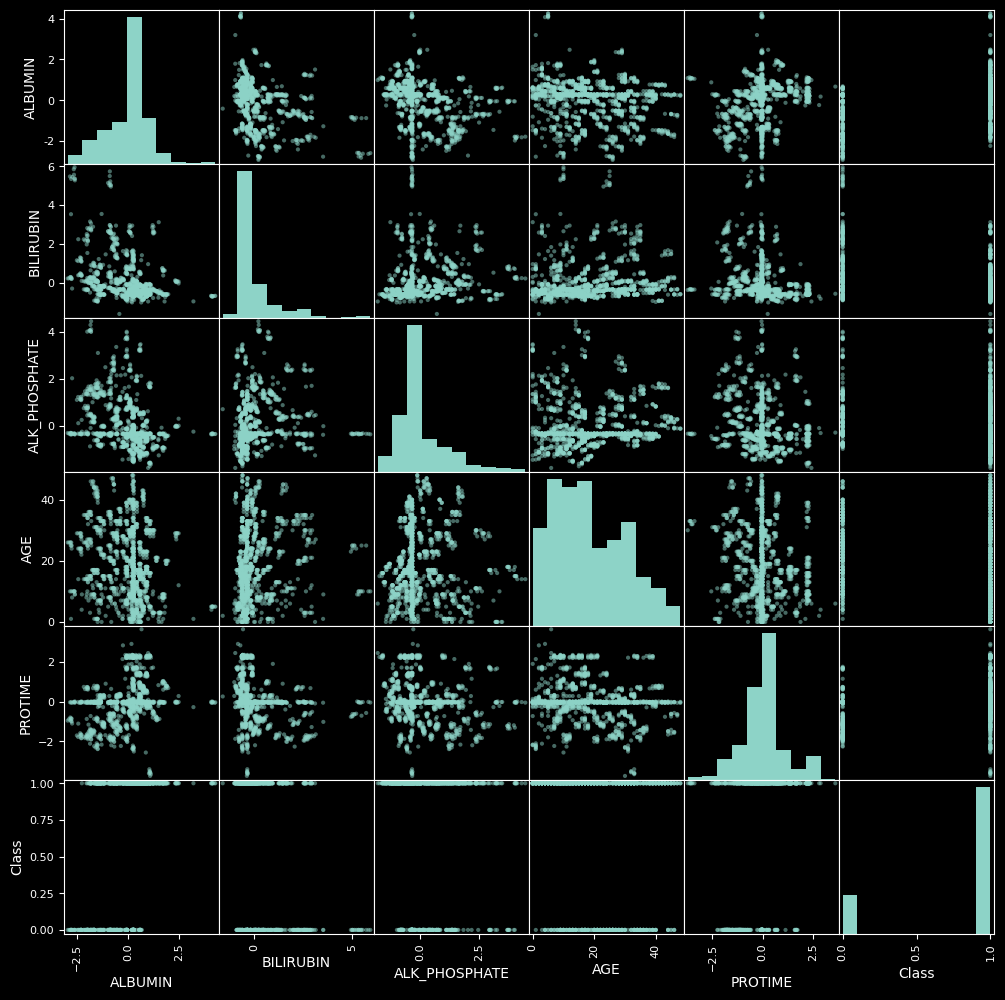

In [8]:
pd.plotting.scatter_matrix(
    pd.concat(train_dfs + test_dfs)[top_5_features.feature.values.tolist() + ["Class"]],
    figsize=(12, 12),
)
plt.show()

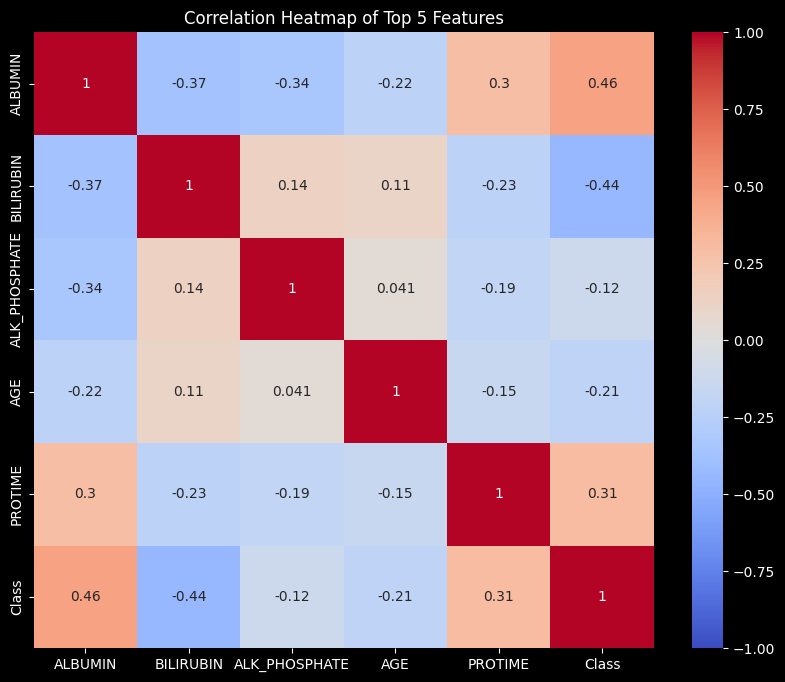

In [9]:
import seaborn as sns

top_5_features_and_class = top_5_features["feature"].tolist() + ["Class"]
corr_matrix = pd.concat(train_dfs + test_dfs)[top_5_features_and_class].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title("Correlation Heatmap of Top 5 Features")
plt.show()